In [1]:
%matplotlib inline

In [2]:
%%bash
pip3 install bluesky-gym
pip3 install gymnasium[classic_control]

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
from gymnasium.wrappers import TimeLimit
import bluesky_gym
bluesky_gym.register_envs()

env = gym.make('SectorCREnv-v0', render_mode='human')
# env = TimeLimit(env, max_episode_steps=200)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/us

Using Python-based geo functions
Reading config from /root/bluesky/settings.cfg
Reading magnetic variation data


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Loading global navigation database...
Reading cache: /root/bluesky/cache/navdata.p
Successfully loaded OpenAP performance model
Failed to load BADA performance model
Successfully loaded legacy performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
# class DQN(nn.Module):

#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 128)
#         self.layer2 = nn.Linear(128, 128)
#         self.layer3 = nn.Linear(128, n_actions)

#     # Called with either one element to determine next action, or a batch
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)
# above is the standard one, but MergeEnv (for example) has the agent learn TWO possible action spaces:
# heading and speed. To support this I editted the architecture to output these two instead the one needed for cartpole

class DQN(nn.Module):
    def __init__(self, n_observations, n_heading, n_speed, hidden_size=128):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        # self.layer3 = nn.Linear(hidden_size, hidden_size//2) # anudda layer

        self.heading_layer = nn.Linear(hidden_size, n_heading)
        self.speed_layer = nn.Linear(hidden_size, n_speed)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # x = F.relu(self.layer3(x))
        heading = self.heading_layer(x)
        speed = self.speed_layer(x)
        return heading, speed

In [8]:
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 5000
TAU = 0.005
LR = 1e-4

In [9]:
# continuous to discrete action space
original_action_space = env.action_space
n_bins_per_dim = 15
action_dim = original_action_space.shape[0]
n_discrete_actions = n_bins_per_dim ** action_dim

In [10]:
def discrete_to_continuous(heading_action, speed_action):
    # basically we are locating where the discrete action is
    # in the continuum of continuous actions using binning
    # imagine a histogram, except were doing it backwards
    heading_low = original_action_space.low[0]
    heading_high = original_action_space.high[0]
    speed_low = original_action_space.low[1]
    speed_high = original_action_space.high[1]

    heading_idx = heading_action.item()
    speed_idx = speed_action.item()

    heading = heading_low + (heading_high - heading_low) * (heading_idx / (n_bins_per_dim - 1))
    speed = speed_low + (speed_high - speed_low) * (speed_idx / (n_bins_per_dim - 1))

    return np.array([heading, speed])

In [11]:
# for some reason bluesky emit's its state a dict
# we need to turn it into a tensor
def state_dict_to_tensor(state_dict):
    values = []
    for key in sorted(state_dict.keys()):
        val = state_dict[key]
        if isinstance(val, np.ndarray):
            values.append(val.flatten())
        else:
            values.append(np.array([val]))
    flat_state = np.concatenate(values)
    return torch.tensor(flat_state, dtype=torch.float32, device=device).unsqueeze(0)

In [12]:
n_actions = n_discrete_actions # 625
state, info = env.reset()
state = state_dict_to_tensor(state)
n_observations = state.shape[-1]

policy_net = DQN(n_observations, n_bins_per_dim, n_bins_per_dim).to(device)
target_net = DQN(n_observations, n_bins_per_dim, n_bins_per_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

In [13]:
steps_done = 0

# need to change this too to support speed and heading
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # return policy_net(state).max(1).indices.view(1, 1)
            heading, speed = policy_net(state)
            heading_action = heading.max(1).indices.view(1, 1)
            speed_action = speed.max(1).indices.view(1, 1)
            return heading_action, speed_action
    else:
        # Explore: sample random DISCRETE actions
        heading_action = torch.tensor(
            [[random.randrange(n_bins_per_dim)]],
            device=device,
            dtype=torch.long
        )
        speed_action = torch.tensor(
            [[random.randrange(n_bins_per_dim)]],
            device=device,
            dtype=torch.long
        )

    return heading_action, speed_action

In [14]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    reward_batch = torch.cat(batch.reward)

    # need to update this as well to have separate losses for heading and speed actions
    heading_action_batch = torch.cat([a[0] for a in batch.action])
    heading_action_batch = heading_action_batch.unsqueeze(1)
    speed_action_batch = torch.cat([a[1] for a in batch.action])
    speed_action_batch = speed_action_batch.unsqueeze(1)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # get q values from the policy
    heading, speed = policy_net(state_batch)
    # get q values for action taken
    state_heading_values = heading.gather(1, heading_action_batch)
    state_speed_values = speed.gather(1, speed_action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # init next state values
    next_heading_values = torch.zeros(BATCH_SIZE, device=device)
    next_speed_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        heading_q_next, speed_q_next = target_net(non_final_next_states)
        next_heading_values[non_final_mask] = heading_q_next.max(1).values
        next_speed_values[non_final_mask] = speed_q_next.max(1).values

    # Compute the expected Q values
    expected_heading_values = (next_heading_values * GAMMA) + reward_batch
    expected_speed_values = (next_speed_values * GAMMA) + reward_batch

    # Compute Huber loss FOR BOTH and combine
    criterion = nn.SmoothL1Loss()
    heading_loss = criterion(state_heading_values, expected_heading_values.unsqueeze(1))
    speed_loss = criterion(state_speed_values, expected_speed_values.unsqueeze(1))
    loss = heading_loss + speed_loss

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

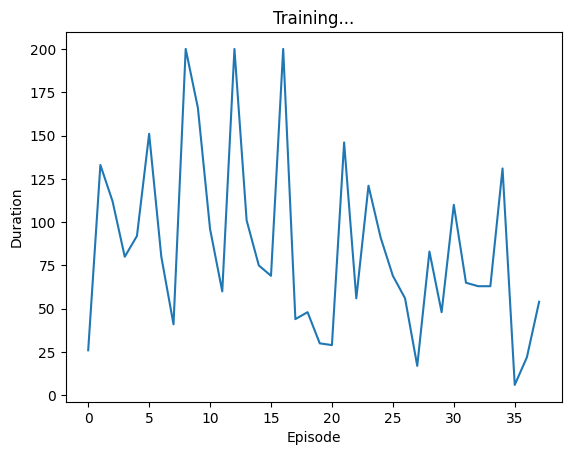

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

episode_rewards = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    total_reward = 0
    state, info = env.reset()
    state = state_dict_to_tensor(state)
    for t in count():
        discrete_action = select_action(state)
        heading_action = discrete_action[0].squeeze(0)
        speed_action = discrete_action[1].squeeze(0)
        continuous_action = discrete_to_continuous(heading_action, speed_action)
        observation, reward, terminated, truncated, _ = env.step(continuous_action)
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = state_dict_to_tensor(observation)

        # Store the transition in memory
        memory.push(state, (heading_action, speed_action), next_state, reward) # storing the DISCRETE action not the continuous for training

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(reward)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
reward_avg = np.convolve(np.array([r.item() for r in episode_rewards]), np.ones(20)/20, mode='valid')
plt.plot(reward_avg)
plt.show()

In [ ]:
env = gym.make('SectorCREnv-v0', render_mode='human')

num_episodes_to_visualize = 5

for episode in range(num_episodes_to_visualize):
    state, info = env.reset()
    state = state_dict_to_tensor(state)

    total_reward = 0
    done = truncated = False
    steps = 0

    while not (done or truncated):
        with torch.no_grad():
            heading_q, speed_q = policy_net(state)
            heading_action = heading_q.max(1).indices.view(1, 1)
            speed_action = speed_q.max(1).indices.view(1, 1)

        continuous_action = discrete_to_continuous(heading_action, speed_action)
        observation, reward, done, truncated, info = env.step(continuous_action)

        state = state_dict_to_tensor(observation)
        total_reward += reward
        steps += 1

    print(f"Episode {episode + 1}: Steps = {steps}, Total Reward = {total_reward}")

env.close()